# Dark Count Rate Analysis
<p style='text-align: justify'>
The dark counts are signals not generated by photon events but by electron emissions, such as thermal emissions from a photocathode. The Dark Count Rate (DCR) is simply the averate rate of recorded events without any source of light in a specific time interval:

$$DCR=\frac{events}{time}$$

The purpose of this analysis is to calculate and plot the DCR for each pixel of Multi-Anode Photolumtpplier Tubes (MaPMTs) to get a distinction of anodes with high counts and an illutrastion of the uniformity of the MaPMTs.
    
The following notebook analyses the Elementary Cell of R-type and H-type in terms of DCR. It saves all the generated plots in the \output file. As there are a lot of plots, only the first plot is shown in the following notebook.
</p>

### Procedure
1. Extract the mapping data.
2. Extract the measurement data.
3. Calculate $DCR$ for each channel.
4. Exclude disabled channels.
5. Produce 2D histograms of a scheme of anodes and $DCR$ as a representation of an Elementary Cell.
6. Produce 1D histograms of $DCR$ for all the channels.

### Libraries
Importing essential libraries: numpy, pandas, matplotlib and seaborn.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

### Load selection
Load refers to a complete measurement of 4 Elementary Cells. The data has been uploaded for 10 loads from two stations.  
- To select a station, provide "S1" or "S2".
- To select a load, provide a number from "0001" up to "00005".
- To select the type of an Elementary Cell, provide either "R" (for loads "0001", "0002" and "0003") or "H" for (loads "0004" and "0005").

In [2]:
station = "S1"
load = "0001"
ectype = "R"

### Mapping data
Extraction of mapping data for an Elementary Cell of R-Type and H-Type. Identification is required to be included in the graphs as there are 1024 channels for R-type and 256 channels for H-type.

In [3]:
ECs_df = pd.DataFrame()

In [4]:
def Mapping(ectype):
    
    map_IDs = []
    map_ECs = []
    map_PMTs = []
    map_anodes = []
    
    if ectype == 'R':
        with open('mapping/R_Map.txt') as file:
            map_data = file.readlines()[1:]
    elif ectype == "H":
        with open('mapping/H_Map.txt') as file:
            map_data = file.readlines()[1:]
    else:
        raise ValueError('Wrong type of an Elementary Cell.')

    for i in range(0, len(map_data)):
        map_channel = map_data[i].split(' ')

        map_ID = ' '.join(map_channel[0:4])
        map_IDs.append(map_ID)

        map_EC = int(map_channel[4])
        map_ECs.append(map_EC)

        if ectype == 'R':
            map_PMT = map_channel[5]
            map_PMTs.append(map_PMT)
            
            map_anode = int(map_channel[6])
            map_anodes.append(map_anode)
        elif ectype == 'H':
            map_anode = int(map_channel[5])
            map_anodes.append(map_anode)

    map_IDs = np.array(map_IDs)
    map_ECs = np.array(map_ECs)
    if ectype == 'R':
        map_PMTs = np.array(map_PMTs)
    map_anodes = np.array(map_anodes)

    ECs_df['ID'] = map_IDs
    ECs_df['EC'] = map_ECs
    if ectype == 'R':
        ECs_df['PMT'] = map_PMTs
    ECs_df['Anode'] = map_anodes

In [5]:
Mapping(ectype)

In [6]:
ECs_df

,ID,EC,PMT,Anode
0,0 0 0 0,3,D,37
1,0 0 0 1,3,D,45
2,0 0 0 2,3,D,38
3,0 0 0 3,3,D,46
4,0 0 0 4,3,D,39
...,...,...,...,...
1019,7 1 7 3,2,B,6
1020,7 1 7 4,2,B,15
1021,7 1 7 5,2,B,7
1022,7 1 7 6,2,B,16


### Measurement data
Extraction of measurement data for the specified load. $DCR$ is calculated immediately. Fortunately, the order of measurement data matches mapping data hence no additional action is required.

In [7]:
def Data(station, load, ectype):
    
    with open(f'data/station-{station[1]}/Load_{load}_{ectype}_{station}/DCR_1000V_cfgOptThr_100s.txt') as file:
        data = file.readlines()[12:]
        
    IDs = []
    counts = []
    
    for i in range(0,len(data)):
        data_channel = data[i]
        
        ID = data_channel.split("\t")[0:4]
        IDs.append(ID)  

        count = int(data_channel.split("\t")[4])/100
        counts.append(count)


    IDs = np.array(IDs)
    counts = np.array(counts)

    IDs_list = IDs.tolist()
    
    ECs_df['Channel_ID'] = IDs_list
    ECs_df['DCR_Counts'] = counts

In [8]:
Data(station, load, ectype)

In [9]:
ECs_df

,ID,EC,PMT,Anode,Channel_ID,DCR_Counts
0,0 0 0 0,3,D,37,"[0, 0, 0, 0]",0.67
1,0 0 0 1,3,D,45,"[0, 0, 0, 1]",0.92
2,0 0 0 2,3,D,38,"[0, 0, 0, 2]",1.03
3,0 0 0 3,3,D,46,"[0, 0, 0, 3]",1.39
4,0 0 0 4,3,D,39,"[0, 0, 0, 4]",0.89
...,...,...,...,...,...,...
1019,7 1 7 3,2,B,6,"[7, 1, 7, 3]",6.56
1020,7 1 7 4,2,B,15,"[7, 1, 7, 4]",3.65
1021,7 1 7 5,2,B,7,"[7, 1, 7, 5]",14.47
1022,7 1 7 6,2,B,16,"[7, 1, 7, 6]",2.64


### Exclusion of disabled channels
For the ECs of H-type, half of the rows are empty as the channels are turned off. Empty rows are indicated by anodes equal to 0. For the ECs of R-type, no cleaning is required as all the channels are active.

In [10]:
def Empty_Anodes_Delete():
    ECs_df.drop(ECs_df[ECs_df['Anode']==0].index, inplace=True)
    ECs_df.reset_index(drop=True, inplace=True)

In [11]:
Empty_Anodes_Delete()

In [12]:
ECs_df

,ID,EC,PMT,Anode,Channel_ID,DCR_Counts
0,0 0 0 0,3,D,37,"[0, 0, 0, 0]",0.67
1,0 0 0 1,3,D,45,"[0, 0, 0, 1]",0.92
2,0 0 0 2,3,D,38,"[0, 0, 0, 2]",1.03
3,0 0 0 3,3,D,46,"[0, 0, 0, 3]",1.39
4,0 0 0 4,3,D,39,"[0, 0, 0, 4]",0.89
...,...,...,...,...,...,...
1019,7 1 7 3,2,B,6,"[7, 1, 7, 3]",6.56
1020,7 1 7 4,2,B,15,"[7, 1, 7, 4]",3.65
1021,7 1 7 5,2,B,7,"[7, 1, 7, 5]",14.47
1022,7 1 7 6,2,B,16,"[7, 1, 7, 6]",2.64


### 2D Histograms (Heatmaps)
The 2D histograms are arranged in 8x8 matrix. For the R-type, there are four 8x8 matrices where each of them is rotated by 90$^{\circ}$ to the preceeding one. For the H-type, there is only one 8x8 matrix. As there are multiple plots to be generated, only the first plot is presented in the notebook, the rest can be seen in .pdf files in the \output folder. Three kinds of histograms can be produced:
- scheme of anodes $\;\;\;$ (analysis = 'anodes'),
- $SIN_{fraction}$ $\;\;\;\;\;\;\;\;\;\;$ (analysis = 'SIN_Fraction'),
- $SIN_{ratio}$ $\;\;\;\;\;\;\;\;\;\;\;\;\;$ (anaysis = 'SN_Ratio').

In [13]:
def Histograms_2D(station, load, ectype, analysis):
    
    if analysis == 'Anode':
        to_title = 'Numbering of Anodes'
        to_map = ListedColormap(['white'])
        to_format = None
        to_fmt = 'g'
        to_cbar = False
    elif analysis == 'DCR_Counts':
        to_title = 'DCR [Hz]'
        to_map = 'coolwarm'
        to_format = None
        to_fmt = '.2f'
        to_cbar = True
    else:
        pass
        
    if ectype=='R':
        EC_0_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_C_matrix = np.array(np.array_split(EC_0_PMT_C[f'{analysis}'].values, 8))
        EC_1_PMT_C_matrix = np.array(np.array_split(EC_1_PMT_C[f'{analysis}'].values, 8))
        EC_2_PMT_C_matrix = np.array(np.array_split(EC_2_PMT_C[f'{analysis}'].values, 8))
        EC_3_PMT_C_matrix = np.array(np.array_split(EC_3_PMT_C[f'{analysis}'].values, 8))

        EC_0_PMT_D_matrix = np.rot90(np.array_split(EC_0_PMT_D[f'{analysis}'].values, 8), k = 3)
        EC_1_PMT_D_matrix = np.rot90(np.array_split(EC_1_PMT_D[f'{analysis}'].values, 8), k = 3)
        EC_2_PMT_D_matrix = np.rot90(np.array_split(EC_2_PMT_D[f'{analysis}'].values, 8), k = 3)
        EC_3_PMT_D_matrix = np.rot90(np.array_split(EC_3_PMT_D[f'{analysis}'].values, 8), k = 3)

        EC_0_PMT_A_matrix = np.rot90(np.array_split(EC_0_PMT_A[f'{analysis}'].values, 8), k = 2)
        EC_1_PMT_A_matrix = np.rot90(np.array_split(EC_1_PMT_A[f'{analysis}'].values, 8), k = 2)
        EC_2_PMT_A_matrix = np.rot90(np.array_split(EC_2_PMT_A[f'{analysis}'].values, 8), k = 2)
        EC_3_PMT_A_matrix = np.rot90(np.array_split(EC_3_PMT_A[f'{analysis}'].values, 8), k = 2)

        EC_0_PMT_B_matrix = np.rot90(np.array_split(EC_0_PMT_B[f'{analysis}'].values, 8), k = 1)
        EC_1_PMT_B_matrix = np.rot90(np.array_split(EC_1_PMT_B[f'{analysis}'].values, 8), k = 1)
        EC_2_PMT_B_matrix = np.rot90(np.array_split(EC_2_PMT_B[f'{analysis}'].values, 8), k = 1)
        EC_3_PMT_B_matrix = np.rot90(np.array_split(EC_3_PMT_B[f'{analysis}'].values, 8), k = 1)

        PMTs_A = [EC_0_PMT_A_matrix, EC_1_PMT_A_matrix, EC_2_PMT_A_matrix, EC_3_PMT_A_matrix]
        PMTs_B = [EC_0_PMT_B_matrix, EC_1_PMT_B_matrix, EC_2_PMT_B_matrix, EC_3_PMT_B_matrix]
        PMTs_C = [EC_0_PMT_C_matrix, EC_1_PMT_C_matrix, EC_2_PMT_C_matrix, EC_3_PMT_C_matrix]
        PMTs_D = [EC_0_PMT_D_matrix, EC_1_PMT_D_matrix, EC_2_PMT_D_matrix, EC_3_PMT_D_matrix]

        for EC in range(0,4):        

            fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 9))

            sns.heatmap(PMTs_A[EC], ax = ax[0,0], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[0,0].get_ylim()
            ax[0,0].set_ylim(bottom + 0.5, top - 0.5)
            ax[0,0].set_title(f'PMT A - {to_title}')

            sns.heatmap(PMTs_B[EC], ax = ax[0,1], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[0,1].get_ylim()
            ax[0,1].set_ylim(bottom + 0.5, top - 0.5)
            ax[0,1].set_title(f'PMT B - {to_title}')

            sns.heatmap(PMTs_D[EC], ax = ax[1,0], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8,}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[1,0].get_ylim()
            ax[1,0].set_ylim(bottom + 0.5, top - 0.5)
            ax[1,0].set_title(f'PMT D - {to_title}')

            sns.heatmap(PMTs_C[EC], ax = ax[1,1], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[1,1].get_ylim()
            ax[1,1].set_ylim(bottom + 0.5, top - 0.5)
            ax[1,1].set_title(f'PMT C - {to_title}')

            fig.tight_layout()
            
            plt.savefig(f"output/{station}_{ectype}_{load}_DCR_Histogram2D_{analysis}_EC_{EC}.pdf")
            
            if EC==0:
                plt.show()
            else:
                plt.close()
            
    elif ectype=='H':
        EC_0 = ECs_df[ECs_df['EC']==0].sort_values(by='Anode')
        EC_1 = ECs_df[ECs_df['EC']==1].sort_values(by='Anode')
        EC_2 = ECs_df[ECs_df['EC']==2].sort_values(by='Anode')
        EC_3 = ECs_df[ECs_df['EC']==3].sort_values(by='Anode')
        
        EC_0_matrix = np.rot90(np.array_split(EC_0[f'{analysis}'].values, 8), k = 2)
        EC_1_matrix = np.rot90(np.array_split(EC_1[f'{analysis}'].values, 8), k = 2)
        EC_2_matrix = np.rot90(np.array_split(EC_2[f'{analysis}'].values, 8), k = 2)
        EC_3_matrix = np.rot90(np.array_split(EC_3[f'{analysis}'].values, 8), k = 2)
        
        ECs = [EC_0_matrix, EC_1_matrix, EC_2_matrix, EC_3_matrix]
        
        for EC in range(0,4):        

            fig = plt.figure(figsize=(12,9))
            ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

            sns.heatmap(ECs[EC], ax = ax, cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            ax.set_title(f'PMT - {to_title}')

            plt.savefig(f"output/{station}_{ectype}_{load}_DCR_Histogram2D_{analysis}_EC_{EC}.pdf")
            
            if EC==0:
                plt.show()
            else:
                plt.close()
    else:
        raise ValueError('Wrong type of an Elementary Cell.')

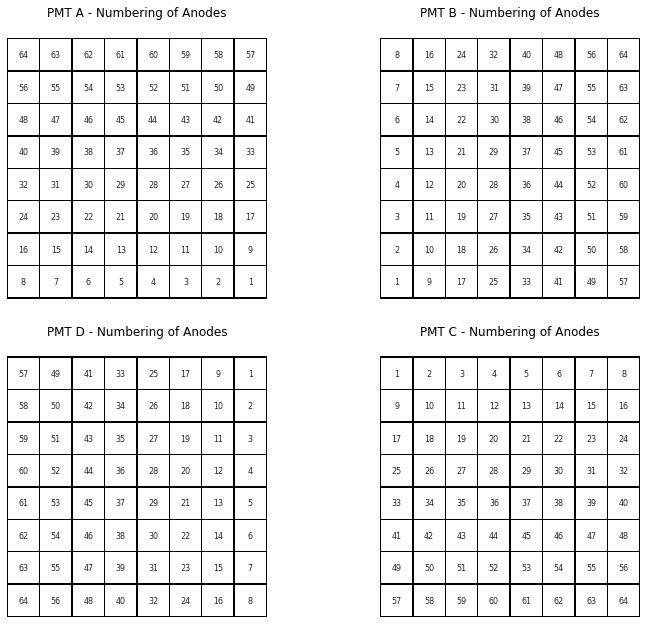

In [14]:
Histograms_2D(station, load, ectype, "Anode")

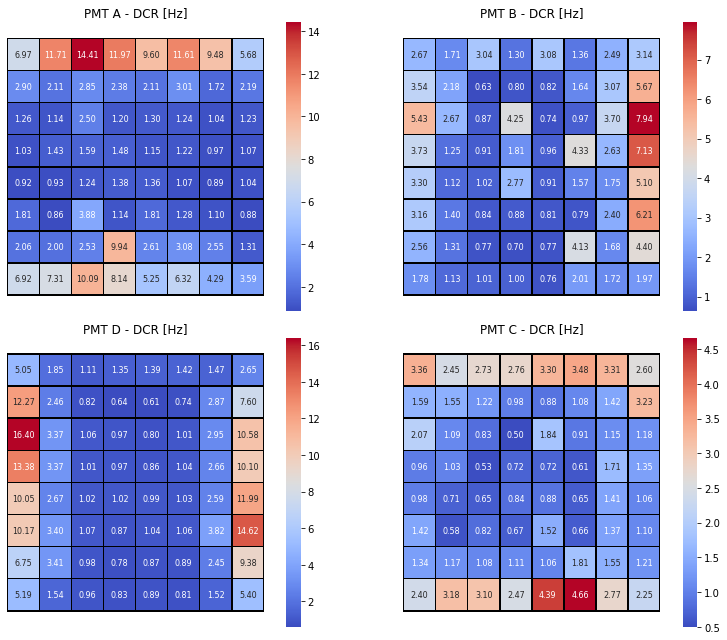

In [15]:
Histograms_2D(station, load, ectype, "DCR_Counts")

### 1D Histograms
The 1D histograms give an insight of the intensity of the SIN for the whole load (4 ECs). Two kinds of histograms can be produced:
- $SIN_{fraction}$ $\;\;\;\;\;\;\;\;\;\;$ (analysis = 'SIN_Fraction'),
- $SIN_{ratio}$ $\;\;\;\;\;\;\;\;\;\;\;\;\;$ (anaysis = 'SN_Ratio').

In [16]:
def Histograms_1D(station, load, ectype, analysis):
    
    if analysis == 'DCR_Counts':
        to_title = 'DCR'
        x_label = 'Counts [Hz]'
        my_bins = 100
    else:
        pass
        
    for EC in range(0, 4):
        if ectype=='R':
            EC_DataFrame = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'PMT', 'Anode']).reset_index(drop=True)
        elif ectype=='H':
            EC_DataFrame = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'Anode']).reset_index(drop=True)
        else:
            raise ValueError('Wrong type of an Elementary Cell.')
            
        fig = plt.figure(figsize=(12,9))
        ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
        ax.set_title(f'{to_title}')
        ax.set_xlabel(f'{x_label}')
        ax.set_ylabel('#')
        
        a = sns.histplot(ECs_df[analysis], kde=False, bins=200, line_kws={'linewidth': '1', 'edgecolor': 'black'})
        
        plt.savefig(f"output/{station}_{ectype}_{load}_DCR_Histogram1D_{analysis}_EC_{EC}.pdf")   
        
        if EC==0:
            plt.show()
        else:
            plt.close()

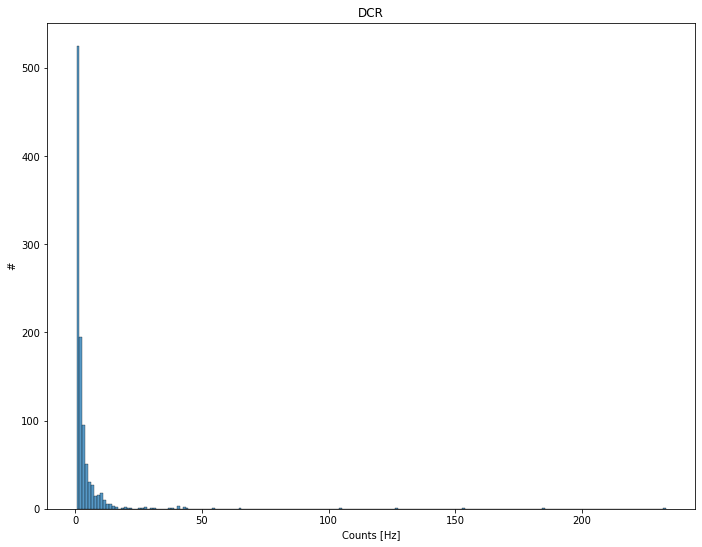

In [17]:
Histograms_1D(station, load, ectype, 'DCR_Counts')